In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


from torch.utils.data import Dataset, TensorDataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
# Load the SMBG dataset
smbg_path = r"C:\Users\Ravisun P R\Downloads\dissertation\dissertation\Glucometer Usage_Data.csv"
smbg_df = pd.read_csv(smbg_path)

# Load the recipes dataset
recipes_path = r"C:\Users\Ravisun P R\Downloads\dissertation\dissertation\recipe\all_recipies.csv"
recipes_df = pd.read_csv(recipes_path)

# Load the nutrient values dataset
nutrient_values_path = r"C:\Users\Ravisun P R\Downloads\dissertation\2021-2023 FNDDS At A Glance - FNDDS Nutrient Values.xlsx"
nutrient_values_df = pd.read_excel(nutrient_values_path, sheet_name=0)

# Load the ingredient nutrient values dataset
ingredient_nutrient_values_path = r"C:\Users\Ravisun P R\Downloads\dissertation\2019-2020 FNDDS At A Glance - Ingredient Nutrient Values (1).xlsx"
ingredient_nutrient_values_df = pd.read_excel(ingredient_nutrient_values_path, sheet_name=0)

#Load the portion  weight values dataset
portions_weights_path = r"C:\Users\Ravisun P R\Downloads\dissertation\2021-2023 FNDDS At A Glance - Portions and Weights.xlsx"
portions_weights_df = pd.read_excel(portions_weights_path, sheet_name=0)
# Explore the SMBG dataset
print("SMBG DataFrame:")
display(smbg_df.head())

# Explore the recipes dataset
print("\nRecipes DataFrame:")
display(recipes_df.head())

# Explore the nutrient values dataset
print("\nNutrient Values DataFrame:")
new_header = nutrient_values_df.iloc[0] 
nutrient_values_df = nutrient_values_df[1:] 
nutrient_values_df.columns = new_header
display(nutrient_values_df.head())

# Explore the ingredient nutrient values dataset
print("\nIngredient Nutrient Values DataFrame:")
new_header = ingredient_nutrient_values_df.iloc[0] 
ingredient_nutrient_values_df = ingredient_nutrient_values_df[1:] 
ingredient_nutrient_values_df.columns = new_header
display(ingredient_nutrient_values_df.head())

print("\nportion Values DataFrame:")
new_header = portions_weights_df.iloc[0] 
portions_weights_df = portions_weights_df[1:] 
portions_weights_df.columns = new_header
display(portions_weights_df.head())


Using device: cuda
SMBG DataFrame:


,Age,Age_groups,Gender,Height (cm),Weight (kg),BMI,Systolic,Diastolic,BP Groups,Duration of Type 2 Diabetes Mellitus (years),...,Medical Condition Dyslipedemia (DL),Medical Condition Obesity,Medical Condition Hyperthyroidism,Medical Condition Heart Disease,Medical conditions,Do you use a Glucometer to check Blood Glucose at home / place of work?,In the past 1 month how many times would you have checked?,In the past 1 month how many times would you have checked_cont?,Have provided Diet counselling to the patient?,Have advised patient on physicial activity requirement?
0,45.0,Age 40-49,Female,157.3,77.7,31.402453,120.0,80.0,Highbloodpressure Stage 1,4.0,...,No,No,No,No,At least One Medical condition,Yes,2.0,2.0,Yes,Yes
1,67.0,Age 60+,Male,170.6,68.2,23.432915,90.0,60.0,Normal,6.0,...,No,No,No,No,No Medical Condition,Yes,2.0,2.0,Yes,Yes
2,69.0,Age 60+,Male,166.3,56.6,20.465951,130.0,70.0,Highbloodpressure Stage 1,5.0,...,No,No,No,No,No Medical Condition,Yes,2.0,2.0,Yes,Yes
3,45.0,Age 40-49,Male,152.4,53.7,23.120880,140.0,90.0,Highbloodpressure Stage 2,5.0,...,No,No,No,No,No Medical Condition,Yes,2.0,2.0,Yes,Yes
4,52.0,Age 50-59,Male,170.0,88.8,30.726644,120.0,80.0,Highbloodpressure Stage 1,10.0,...,No,No,No,No,No Medical Condition,Yes,NaN,NaN,Yes,Yes



Recipes DataFrame:


,recipe_name,rating,reviews,description,published_date,prep_time,cook_time,total_time,servings,calories,fat,carbs,protein
0,Air Fryer Ham and Cheese Wraps,NaN,0,These air fryer ham and cheese wraps couldn’t ...,"Published on October 23, 2023",4 mins,6 mins,10 mins,2,612.0,33g,57g,22g
1,Air Fryer New York Strip Steak,NaN,0,"These New York strip steaks were quite good, d...","Published on August 3, 2023",5 mins,10 mins,30 mins,10 mins,704.0,50g,0g,59g
2,Air Fryer Crispy Beef and Broccoli,4.4,4 Reviews,Use your air fryer for this crispy beef and br...,"Published on June 21, 2023",20 mins,10 mins,30 mins,4,521.0,22g,45g,37g
3,Air Fryer Pecan Crusted Trout,NaN,0,This pecan crusted trout cooked in the air fry...,"Published on June 21, 2023",10 mins,10 mins,20 mins,4,387.0,24g,9g,34g
4,Air Fryer Everything-Bagel Salmon Dinner,4.0,1 Review,Salmon fillets are flavored with everything ba...,"Published on June 21, 2023",15 mins,20 mins,35 mins,2,589.0,32g,33g,43g



Nutrient Values DataFrame:


,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
1,11100000,"Milk, NFS",1004,"Milk, reduced fat",52,3.33,4.83,4.88,0,2.14,...,0.002,0,0.074,0.008,0,0.003,0,0.001,0,88.92
2,11111000,"Milk, whole",1002,"Milk, whole",61,3.27,4.63,4.81,0,3.2,...,0.004,0,0.115,0.013,0,0.004,0.001,0.002,0,88.1
3,11112110,"Milk, reduced fat (2%)",1004,"Milk, reduced fat",50,3.36,4.9,4.89,0,1.9,...,0.002,0,0.061,0.007,0,0.003,0,0.001,0,89.1
4,11112210,"Milk, low fat (1%)",1006,"Milk, lowfat",43,3.38,5.18,4.96,0,0.95,...,0.001,0,0.033,0.004,0,0.001,0,0,0,89.7
5,11113000,"Milk, fat free (skim)",1008,"Milk, nonfat",34,3.43,4.92,5.05,0,0.08,...,0,0,0.005,0,0,0,0,0,0,90.8



Ingredient Nutrient Values DataFrame:


,Ingredient code,Ingredient description,Nutrient code,Nutrient description,Nutrient value,Nutrient value source,FDC ID,Derivation code,SR AddMod year,Foundation year acquired
1,1001,"Butter, stick, salted",203,Protein,0.85,SR Legacy,173410,NaN,1976,NaN
2,1001,"Butter, stick, salted",204,Total Fat,82.2,Foundation,790508,A,NaN,2019
3,1001,"Butter, stick, salted",205,Carbohydrate,0.06,SR Legacy,173410,NC,1976,NaN
4,1001,"Butter, stick, salted",208,Energy,743,Informed by FDC Foundation and SR Legacy,NaN,NaN,NaN,NaN
5,1001,"Butter, stick, salted",221,Alcohol,0,SR Legacy,173410,NaN,1985,NaN



portion Values DataFrame:


,Food code,Main food description,WWEIA Category number,WWEIA Category description,Seq num,Portion description,Portion weight\n(g)
1,11000000,"Milk, human",9602,Human milk,1,1 cup,246
2,11000000,"Milk, human",9602,Human milk,2,Quantity not specified,0
3,11000000,"Milk, human",9602,Human milk,3,1 fl oz,30.8
4,11100000,"Milk, NFS",1004,"Milk, reduced fat",1,1 cup,244
5,11100000,"Milk, NFS",1004,"Milk, reduced fat",2,1 fl oz,30.5


In [13]:
# Assuming 'correct_food_code_column' is the actual column name in both dataframes
merged_df = pd.merge(nutrient_values_df, portions_weights_df, on='Food code', how='inner')
# Check for missing values
print(merged_df.isnull().sum())

# Fill missing values or drop them
merged_df = merged_df.dropna()  # or fillna() depending on your strategy
scaler = StandardScaler()
numeric_columns = ['Energy (kcal)', 'Protein (g)', 'Carbohydrate (g)', 'Total Fat (g)']
merged_df[numeric_columns] = scaler.fit_transform(merged_df[numeric_columns])

0
Food code                       0
Main food description_x         0
WWEIA Category number_x         0
WWEIA Category description_x    0
Energy (kcal)                   0
                               ..
WWEIA Category number_y         0
WWEIA Category description_y    0
Seq num                         0
Portion description             0
Portion weight\n(g)             0
Length: 75, dtype: int64


In [14]:
# Check for missing values in SMBG dataset
print("Missing values in SMBG dataset:")
print(smbg_df.isnull().sum())

# Drop rows with missing SMBG data if necessary
smbg_df = smbg_df.dropna(subset=['Glucose  PP (mg/dL)', 'FBS(Fasting Blood Sugar) (mg/dL)', 'BMI'])

# Fill missing values for other columns (if any)
smbg_df = smbg_df.fillna(method='ffill').fillna(method='bfill')

# Ensure numeric columns are in the correct format
smbg_df['Glucose  PP (mg/dL)'] = smbg_df['Glucose  PP (mg/dL)'].astype(float)
smbg_df['FBS(Fasting Blood Sugar) (mg/dL)'] = smbg_df['FBS(Fasting Blood Sugar) (mg/dL)'].astype(float)
smbg_df['BMI'] = smbg_df['BMI'].astype(float)
smbg_df[['Glucose  PP (mg/dL)', 'HbA1c (%)', 'RBS (Random Blood Sugar) (mg/dL)','FBS(Fasting Blood Sugar) (mg/dL)']] = smbg_df[['Glucose  PP (mg/dL)', 'HbA1c (%)', 'RBS (Random Blood Sugar) (mg/dL)','FBS(Fasting Blood Sugar) (mg/dL)']].map(lambda x: np.round(x, 2))

# Review cleaned data
print("\nCleaned SMBG DataFrame:")
print(smbg_df.head())


Missing values in SMBG dataset:
Age                                                                           0
Age_groups                                                                    0
Gender                                                                        0
Height (cm)                                                                1589
Weight (kg)                                                                  31
BMI                                                                        1587
Systolic                                                                     35
Diastolic                                                                    43
BP Groups                                                                     0
Duration of Type 2 Diabetes Mellitus (years)                                474
Duration                                                                      0
Glucose  PP (mg/dL)                                                         490
HbA1c (%

C:\Users\Ravisun P R\AppData\Local\Temp\ipykernel_27708\1345841290.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smbg_df = smbg_df.fillna(method='ffill').fillna(method='bfill')


In [15]:
nutrients_of_interest = ['Carbohydrate', 'Protein', 'Total lipid (fat)']  # Adjust these as needed
filtered_nutrients_df = ingredient_nutrient_values_df[ingredient_nutrient_values_df['Nutrient description'].isin(nutrients_of_interest)]
ingredient_nutrients_pivoted = filtered_nutrients_df.pivot_table(
    index='Ingredient code',
    columns='Nutrient description',
    values='Nutrient value'
).reset_index()
display(ingredient_nutrients_pivoted.head())
unique_nutrients = ingredient_nutrient_values_df['Nutrient description'].unique()
print(unique_nutrients)


Nutrient description,Ingredient code,Carbohydrate,Protein
0,1001,0.06,0.85
1,1002,0.0,0.49
2,1003,0.0,0.28
3,1004,2.34,21.4
4,1005,2.79,23.24


['Protein' 'Total Fat' 'Carbohydrate' 'Energy' 'Alcohol' 'Water'
 'Caffeine' 'Theobromine' 'Sugars, total' 'Fiber, total dietary' 'Calcium'
 'Iron' 'Magnesium' 'Phosphorus' 'Potassium' 'Sodium' 'Zinc' 'Copper'
 'Selenium' 'Retinol' 'Vitamin A, RAE' 'Carotene, beta' 'Carotene, alpha'
 'Vitamin E (alpha-tocopherol)' 'Vitamin D (D2 + D3)'
 'Cryptoxanthin, beta' 'Lycopene' 'Lutein + zeaxanthin' 'Vitamin C'
 'Thiamin' 'Riboflavin' 'Niacin' 'Vitamin B-6' 'Folate, total'
 'Vitamin B-12' 'Choline, total' 'Vitamin K (phylloquinone)' 'Folic acid'
 'Folate, food' 'Folate, DFE' 'Vitamin E, added' 'Vitamin B-12, added'
 'Cholesterol' 'Fatty acids, total saturated' '4:0' '6:0' '8:0' '10:0'
 '12:0' '14:0' '16:0' '18:0' '18:1' '18:2' '18:3' '20:4' '22:6 n-3' '16:1'
 '18:4' '20:1' '20:5 n-3' '22:1' '22:5 n-3'
 'Fatty acids, total monounsaturated' 'Fatty acids, total polyunsaturated']


In [16]:
portions_weights_path = r"C:\Users\Ravisun P R\Downloads\dissertation\2021-2023 FNDDS At A Glance - Portions and Weights.xlsx"
portions_weights_df = pd.read_excel(portions_weights_path, sheet_name=0)
display(ingredient_nutrient_values_df.head())
display(portions_weights_df.head())
relevant_nutrients = ['Carbohydrate', 'Protein', 'Total lipid (fat)']  # Example nutrients
filtered_nutrient_df = ingredient_nutrient_values_df[ingredient_nutrient_values_df['Nutrient description'].isin(relevant_nutrients)]


,Ingredient code,Ingredient description,Nutrient code,Nutrient description,Nutrient value,Nutrient value source,FDC ID,Derivation code,SR AddMod year,Foundation year acquired
1,1001,"Butter, stick, salted",203,Protein,0.85,SR Legacy,173410,NaN,1976,NaN
2,1001,"Butter, stick, salted",204,Total Fat,82.2,Foundation,790508,A,NaN,2019
3,1001,"Butter, stick, salted",205,Carbohydrate,0.06,SR Legacy,173410,NC,1976,NaN
4,1001,"Butter, stick, salted",208,Energy,743,Informed by FDC Foundation and SR Legacy,NaN,NaN,NaN,NaN
5,1001,"Butter, stick, salted",221,Alcohol,0,SR Legacy,173410,NaN,1985,NaN


,Portions and Weights\n2021-2023 Food and Nutrient Database for Dietary Studies - At A Glance,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Food code,Main food description,WWEIA Category number,WWEIA Category description,Seq num,Portion description,Portion weight\n(g)
1,11000000,"Milk, human",9602,Human milk,1,1 cup,246
2,11000000,"Milk, human",9602,Human milk,2,Quantity not specified,0
3,11000000,"Milk, human",9602,Human milk,3,1 fl oz,30.8
4,11100000,"Milk, NFS",1004,"Milk, reduced fat",1,1 cup,244


In [17]:
# Check for missing values in Recipes dataset
print("Missing values in Recipes dataset:")
print(recipes_df.isnull().sum())

# Drop rows with missing data in nutritional columns
recipes_df = recipes_df.dropna(subset=['calories', 'fat', 'carbs', 'protein'])

# Ensure numeric columns are in the correct format
if recipes_df.carbs.dtype != 'float64':
    recipes_df[['fat', 'carbs', 'protein']] = recipes_df[['fat', 'carbs', 'protein']].map(lambda x: float(str(x).replace('mg', '')) / 1000 if "mg" in x else str(x).replace('g',''))
    recipes_df[['calories', 'fat', 'carbs', 'protein']] = recipes_df[['calories', 'fat', 'carbs', 'protein']].apply(pd.to_numeric)

# recipes_df['calories'] = recipes_df['calories'][:-1].astype(float)
# recipes_df['fat'] = recipes_df['fat'][:-1].astype(float)
# recipes_df['carbs'] = recipes_df['carbs'][:-1].astype(float)
# recipes_df['protein'] = recipes_df['protein'][:-1].astype(float)

# Review cleaned data
print("\nCleaned Recipes DataFrame:")
print(recipes_df.head())


Missing values in Recipes dataset:
recipe_name          4
rating            6226
reviews              0
description          0
published_date       4
prep_time         2020
cook_time         2043
total_time        3871
servings          6168
calories          2854
fat               2858
carbs             3102
protein           4080
dtype: int64

Cleaned Recipes DataFrame:
                                recipe_name  rating    reviews  \
0            Air Fryer Ham and Cheese Wraps     NaN          0   
1            Air Fryer New York Strip Steak     NaN          0   
2        Air Fryer Crispy Beef and Broccoli     4.4  4 Reviews   
3             Air Fryer Pecan Crusted Trout     NaN          0   
4  Air Fryer Everything-Bagel Salmon Dinner     4.0   1 Review   

                                         description  \
0  These air fryer ham and cheese wraps couldn’t ...   
1  These New York strip steaks were quite good, d...   
2  Use your air fryer for this crispy beef and br...   
3  T

In [18]:
# Check for missing values in Nutrient Values dataset
print("Missing values in Nutrient Values dataset:")
print(nutrient_values_df.isnull().sum())

# Identify and rename relevant columns for easier access (this might be necessary depending on the dataset's structure)
nutrient_values_df.columns = nutrient_values_df.columns.str.strip()

# Review cleaned data
print("\nCleaned Nutrient Values DataFrame:")

display(nutrient_values_df.head())


Missing values in Nutrient Values dataset:
0
Food code                     0
Main food description         0
WWEIA Category number         0
WWEIA Category description    0
Energy (kcal)                 0
                             ..
20:4\n(g)                     0
20:5 n-3\n(g)                 0
22:5 n-3\n(g)                 0
22:6 n-3\n(g)                 0
Water\n(g)                    0
Length: 69, dtype: int64

Cleaned Nutrient Values DataFrame:


,Food code,Main food description,WWEIA Category number,WWEIA Category description,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)","Fiber, total dietary (g)",Total Fat (g),...,20:1\n(g),22:1\n(g),18:2\n(g),18:3\n(g),18:4\n(g),20:4\n(g),20:5 n-3\n(g),22:5 n-3\n(g),22:6 n-3\n(g),Water\n(g)
1,11100000,"Milk, NFS",1004,"Milk, reduced fat",52,3.33,4.83,4.88,0,2.14,...,0.002,0,0.074,0.008,0,0.003,0,0.001,0,88.92
2,11111000,"Milk, whole",1002,"Milk, whole",61,3.27,4.63,4.81,0,3.2,...,0.004,0,0.115,0.013,0,0.004,0.001,0.002,0,88.1
3,11112110,"Milk, reduced fat (2%)",1004,"Milk, reduced fat",50,3.36,4.9,4.89,0,1.9,...,0.002,0,0.061,0.007,0,0.003,0,0.001,0,89.1
4,11112210,"Milk, low fat (1%)",1006,"Milk, lowfat",43,3.38,5.18,4.96,0,0.95,...,0.001,0,0.033,0.004,0,0.001,0,0,0,89.7
5,11113000,"Milk, fat free (skim)",1008,"Milk, nonfat",34,3.43,4.92,5.05,0,0.08,...,0,0,0.005,0,0,0,0,0,0,90.8


In [19]:
# Check for missing values in Ingredient Nutrient Values dataset
print("Missing values in Ingredient Nutrient Values dataset:")
display(ingredient_nutrient_values_df.head())
print(ingredient_nutrient_values_df.isnull().sum())

# Identify and rename relevant columns for easier access
ingredient_nutrient_values_df.columns = ingredient_nutrient_values_df.columns.str.strip()
ingredient_nutrient_values_df = ingredient_nutrient_values_df.dropna()
# Review cleaned data
#print("\nCleaned Ingredient Nutrient Values DataFrame:")
display(ingredient_nutrient_values_df.head())


Missing values in Ingredient Nutrient Values dataset:


,Ingredient code,Ingredient description,Nutrient code,Nutrient description,Nutrient value,Nutrient value source,FDC ID,Derivation code,SR AddMod year,Foundation year acquired
1,1001,"Butter, stick, salted",203,Protein,0.85,SR Legacy,173410,NaN,1976,NaN
2,1001,"Butter, stick, salted",204,Total Fat,82.2,Foundation,790508,A,NaN,2019
3,1001,"Butter, stick, salted",205,Carbohydrate,0.06,SR Legacy,173410,NC,1976,NaN
4,1001,"Butter, stick, salted",208,Energy,743,Informed by FDC Foundation and SR Legacy,NaN,NaN,NaN,NaN
5,1001,"Butter, stick, salted",221,Alcohol,0,SR Legacy,173410,NaN,1985,NaN


0
Ingredient code                  0
Ingredient description           0
Nutrient code                    0
Nutrient description             0
Nutrient value                   0
Nutrient value source            0
FDC ID                        4529
Derivation code              35525
SR AddMod year                6748
Foundation year acquired    119663
dtype: int64


,Ingredient code,Ingredient description,Nutrient code,Nutrient description,Nutrient value,Nutrient value source,FDC ID,Derivation code,SR AddMod year,Foundation year acquired


In [20]:
# Extract relevant features from the SMBG dataset
smbg_features = smbg_df[['BMI', 'Glucose  PP (mg/dL)', 'HbA1c (%)', 'FBS(Fasting Blood Sugar) (mg/dL)']]

# Extract relevant features from the Recipes dataset
recipe_features = recipes_df[['calories', 'fat', 'carbs', 'protein','recipe_name']]
scaler = StandardScaler()

numeric_columns = ['Energy (kcal)', 'Protein (g)', 'Carbohydrate (g)', 'Total Fat (g)']
merged_df[numeric_columns] = scaler.fit_transform(merged_df[numeric_columns])
# If needed, extract features from the nutrient values dataset
# nutrient_values_features = nutrient_values_df[...]
# ingredient_nutrient_values_features = ingredient_nutrient_values_df[...]
merged_features = merged_df[['Food code', 'Energy (kcal)', 'Protein (g)',
       'Carbohydrate (g)', 'Sugars, total\n(g)', 
       'Total Fat (g)',
       'Portion weight\n(g)']]
# Review extracted features
print("SMBG Features:")
display(smbg_features.head())

print("\nRecipe Features:")
display(recipe_features.head())

print("\nNutrients Features:")
display(merged_features.head())

SMBG Features:


,BMI,Glucose PP (mg/dL),HbA1c (%),FBS(Fasting Blood Sugar) (mg/dL)
0,31.402453,198.8,4.5,122.2
1,23.432915,125.0,6.5,65.8
2,20.465951,155.5,6.2,85.6
3,23.120880,208.5,7.8,145.2
4,30.726644,180.0,7.6,185.0



Recipe Features:


,calories,fat,carbs,protein,recipe_name
0,612.0,33,57.0,22,Air Fryer Ham and Cheese Wraps
1,704.0,50,0.0,59,Air Fryer New York Strip Steak
2,521.0,22,45.0,37,Air Fryer Crispy Beef and Broccoli
3,387.0,24,9.0,34,Air Fryer Pecan Crusted Trout
4,589.0,32,33.0,43,Air Fryer Everything-Bagel Salmon Dinner



Nutrients Features:


,Food code,Energy (kcal),Protein (g),Carbohydrate (g),"Sugars, total\n(g)",Total Fat (g),Portion weight\n(g)
0,11100000,-1.089917,-0.672306,-0.781307,4.88,-0.66453,244
1,11100000,-1.089917,-0.672306,-0.781307,4.88,-0.66453,30.5
2,11100000,-1.089917,-0.672306,-0.781307,4.88,-0.66453,244
3,11100000,-1.089917,-0.672306,-0.781307,4.88,-0.66453,2.5
4,11100000,-1.089917,-0.672306,-0.781307,4.88,-0.66453,61


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming you have already extracted and cleaned the features as shown in your code

# Combine the features from SMBG, Recipes, and Merged datasets
min_size = min(smbg_features.shape[0], recipe_features.shape[0], merged_features.shape[0])

smbg_features = smbg_features.iloc[:min_size]
recipe_features = recipe_features.iloc[:min_size]
merged_features = merged_features.iloc[:min_size]

# Combine features horizontally
combined_features = pd.concat([smbg_features, recipe_features, merged_features], axis=1)

# Drop the target variable column from the combined features
features = combined_features.drop(columns=['HbA1c (%)'])
targets = combined_features['HbA1c (%)']

# Separate numeric and non-numeric features
numeric_features = features.select_dtypes(include=[np.number])
non_numeric_features = features.select_dtypes(exclude=[np.number])

# Impute missing values in the numeric features
imputer = SimpleImputer(strategy='mean')
numeric_features_imputed = imputer.fit_transform(numeric_features)

# If necessary, handle non-numeric features (e.g., drop them, or use encoding if categorical)
# For simplicity, let's drop the non-numeric features in this example
features_imputed = pd.DataFrame(numeric_features_imputed, columns=numeric_features.columns)

# Convert features and targets to numpy arrays (if not already)
features_np = features_imputed.to_numpy()
targets_np = targets.to_numpy()

# Split the data into training and testing sets
train_features, test_features, train_targets, test_targets = train_test_split(
    features_np, targets_np, test_size=0.2, random_state=42
)

# Further, you can normalize or scale the data if necessary
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Apply PCA
pca = PCA(n_components=0.95)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

# Convert the PCA-transformed features back to tensors
train_features_tensor = torch.tensor(train_features_pca, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features_pca, dtype=torch.float32)
test_targets_tensor = torch.tensor(test_targets, dtype=torch.float32)

# Now you can create TensorDatasets and DataLoaders for your training and testing data
train_dataset = TensorDataset(train_features_tensor, train_targets_tensor)
test_dataset = TensorDataset(test_features_tensor, test_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training and testing datasets prepared.")


Training and testing datasets prepared.


In [22]:
print(merged_df.columns)

# Assuming all datasets are aligned (same number of rows)
combined_features = pd.concat([smbg_features, recipe_features, merged_features], axis=1)
# Assuming your combined_features DataFrame contains the necessary columns
# Select the 4 features: 'glucose', 'height', 'weight', and 'HbA1c'



Index(['Food code', 'Main food description_x', 'WWEIA Category number_x',
       'WWEIA Category description_x', 'Energy (kcal)', 'Protein (g)',
       'Carbohydrate (g)', 'Sugars, total\n(g)', 'Fiber, total dietary (g)',
       'Total Fat (g)', 'Fatty acids, total saturated (g)',
       'Fatty acids, total monounsaturated (g)',
       'Fatty acids, total polyunsaturated (g)', 'Cholesterol (mg)',
       'Retinol (mcg)', 'Vitamin A, RAE (mcg_RAE)', 'Carotene, alpha (mcg)',
       'Carotene, beta (mcg)', 'Cryptoxanthin, beta (mcg)', 'Lycopene (mcg)',
       'Lutein + zeaxanthin (mcg)', 'Thiamin (mg)', 'Riboflavin (mg)',
       'Niacin (mg)', 'Vitamin B-6 (mg)', 'Folic acid (mcg)',
       'Folate, food (mcg)', 'Folate, DFE (mcg_DFE)', 'Folate, total (mcg)',
       'Choline, total (mg)', 'Vitamin B-12 (mcg)',
       'Vitamin B-12, added\n(mcg)', 'Vitamin C (mg)',
       'Vitamin D (D2 + D3) (mcg)', 'Vitamin E (alpha-tocopherol) (mg)',
       'Vitamin E, added\n(mg)', 'Vitamin K (phylloquin

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Separate numeric and non-numeric features
smbg_numeric_features = smbg_features.select_dtypes(include=[np.number])
recipe_numeric_features = recipe_features.select_dtypes(include=[np.number])
merged_numeric_features = merged_features.select_dtypes(include=[np.number])

# Initialize the scaler
scaler = StandardScaler()

# Normalize SMBG features
smbg_features_scaled = scaler.fit_transform(smbg_numeric_features)

# Normalize Recipe features
recipe_features_scaled = scaler.fit_transform(recipe_numeric_features)

# Normalize Merged features
merged_features_scaled = scaler.fit_transform(merged_numeric_features)

print("Normalized SMBG Features:")
display(smbg_features_scaled[:5])

print("\nNormalized Recipe Features:")
display(recipe_features_scaled[:5])

print("\nNormalized Merged Features:")
display(merged_features_scaled[:5])


Normalized SMBG Features:


array([[ 0.95612876, -0.22797285, -1.75717478, -0.43607842],
       [-0.46495016, -1.03433734, -0.80957497, -1.23489313],
       [-0.99400094, -0.70108373, -0.95171494, -0.95445818],
       [-0.52059044, -0.12198728, -0.1936351 , -0.11032065],
       [ 0.83562259, -0.4333882 , -0.28839508,  0.45338193]])


Normalized Recipe Features:


array([[ 0.95098917,  0.84043921,  0.80851652,  0.49050831],
       [ 1.2415897 ,  1.67448388, -0.84043592,  2.57846572],
       [ 0.66354734,  0.30076324,  0.46136864,  1.33697753],
       [ 0.24028135,  0.39888614, -0.58007501,  1.16768368],
       [ 0.87833904,  0.79137775,  0.11422075,  1.67556522]])


Normalized Merged Features:


array([[-0.75150752, -0.14395253, -0.67854149, -0.49301138],
       [-0.75150752, -0.14395253, -0.67854149, -0.49301138],
       [-0.75150752, -0.14395253, -0.67854149, -0.49301138],
       [-0.75150752, -0.14395253, -0.67854149, -0.49301138],
       [-0.75150752, -0.14395253, -0.67854149, -0.49301138]])

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import numpy as np

# Assuming your data is already preprocessed and scaled
# Convert data to PyTorch tensors
smbg_tensor = torch.tensor(smbg_features_scaled, dtype=torch.float32)
recipe_tensor = torch.tensor(recipe_features_scaled, dtype=torch.float32)
merged_tensor = torch.tensor(merged_features_scaled, dtype=torch.float32)

# Ensure all tensors have the same number of rows
min_size = min(smbg_tensor.shape[0], recipe_tensor.shape[0], merged_tensor.shape[0])
smbg_tensor = smbg_tensor[:min_size]
recipe_tensor = recipe_tensor[:min_size]
merged_tensor = merged_tensor[:min_size]

# Concatenate the tensors along the last dimension (feature dimension)
combined_features_tensor = torch.cat([smbg_tensor, recipe_tensor, merged_tensor], dim=1)
print(f"Combined Features Tensor Shape: {combined_features_tensor.shape}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain enough components to explain 95% of variance
pca_features = pca.fit_transform(combined_features_tensor.numpy())

# Convert PCA features back to a tensor
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)
print(f"PCA Features Tensor Shape: {pca_features_tensor.shape}")

# Assuming you have a target tensor `smbg_targets` aligned with `smbg_tensor`
smbg_targets = smbg_df['HbA1c (%)'].values  # Adjust this to your actual target column
smbg_targets = torch.tensor(smbg_targets[:min_size], dtype=torch.float32)

# Split into training and validation sets
train_features_tensor, val_features_tensor, train_targets_tensor, val_targets_tensor = train_test_split(
    pca_features_tensor, smbg_targets, test_size=0.2, random_state=42
)

# Create TensorDatasets and DataLoader objects
train_dataset = TensorDataset(train_features_tensor, train_targets_tensor)
val_dataset = TensorDataset(val_features_tensor, val_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Transformer Model Definition
class DietaryTransformerModel(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, hidden_dim, dropout=0.3):
        super(DietaryTransformerModel, self).__init__()
        
        # Transformer encoder layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim,  # This should match the PCA output dimension
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Match input_dim here
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)  # Output is a single value

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Transformer encoder expects input in [batch_size, sequence_length, input_dim]
        x = self.transformer(x)
        
        # Fully connected layers expect input in [batch_size, input_dim]
        # Flatten sequence length and input_dim for the fully connected layers
        x = x.mean(dim=1)  # Global average pooling over the sequence length
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Initialize the model
input_dim = pca_features_tensor.shape[1]  # Update input dimension based on PCA output
num_layers = 2
num_heads = 2 # Set num_heads to 3 as it divides 9 evenly
hidden_dim = 32
dropout = 0.5

model = DietaryTransformerModel(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, hidden_dim=hidden_dim, dropout=dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses = []
val_losses = []
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_features, batch_targets in train_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        optimizer.zero_grad()
        output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
        loss = criterion(output.squeeze(), batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    # Validation phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_targets_list = []
    with torch.no_grad():
        for batch_features, batch_targets in val_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
            loss = criterion(output.squeeze(), batch_targets)
            val_loss += loss.item()

            val_predictions.extend(output.cpu().numpy())
            val_targets_list.extend(batch_targets.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predictions = np.array(val_predictions).flatten()
    val_targets_list = np.array(val_targets_list).flatten()
    # Calculate R-squared
    r2 = r2_score(val_targets_list, val_predictions)
    r2_scores.append(r2)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, R-squared: {r2:.4f}')
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break



Combined Features Tensor Shape: torch.Size([890, 12])
PCA Features Tensor Shape: torch.Size([890, 8])


c:\Users\Ravisun P R\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\Ravisun P R\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Ravisun P R\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_at

Epoch [1/50], Train Loss: 68.2322, Val Loss: 62.6245, R-squared: -12.3801
Epoch [2/50], Train Loss: 54.0448, Val Loss: 41.7003, R-squared: -7.9476
Epoch [3/50], Train Loss: 29.6887, Val Loss: 12.1376, R-squared: -1.6561
Epoch [4/50], Train Loss: 8.4855, Val Loss: 6.1903, R-squared: -0.3037
Epoch [5/50], Train Loss: 5.7431, Val Loss: 5.1124, R-squared: -0.0827
Epoch [6/50], Train Loss: 5.6111, Val Loss: 4.6508, R-squared: 0.0117
Epoch [7/50], Train Loss: 5.1365, Val Loss: 4.4854, R-squared: 0.0485
Epoch [8/50], Train Loss: 4.8926, Val Loss: 4.4989, R-squared: 0.0482
Epoch [9/50], Train Loss: 4.7303, Val Loss: 4.0670, R-squared: 0.1327
Epoch [10/50], Train Loss: 4.5001, Val Loss: 4.1142, R-squared: 0.1263
Epoch [11/50], Train Loss: 4.1539, Val Loss: 3.3190, R-squared: 0.2821
Epoch [12/50], Train Loss: 4.2872, Val Loss: 3.3500, R-squared: 0.2803
Epoch [13/50], Train Loss: 3.6222, Val Loss: 2.7691, R-squared: 0.4001
Epoch [14/50], Train Loss: 3.7429, Val Loss: 2.4208, R-squared: 0.4741
Epo

In [25]:
print("Train Losses:", train_losses)
print("Validation Losses:", val_losses)
print("R-squared Scores:", r2_scores)


Train Losses: [68.2321608170219, 54.04475734544837, 29.68874052296514, 8.485480132310286, 5.74305276248766, 5.611143039620441, 5.136473800825036, 4.892588459927103, 4.730328456215236, 4.500124050223309, 4.15389669459799, 4.287213646847269, 3.6221943264422207, 3.742897489796514, 3.250905244246773, 3.161795481391575, 3.447239689205004, 3.0242003150608228, 2.6931588286938877, 2.766383487245311, 2.574206935322803, 2.3926108194434126, 2.404473258101422, 2.2016900000364883, 2.2142890121625816, 2.0400959408801533, 2.0316531658172607, 1.896245891633241, 2.0322327639745628, 2.146498610144076, 1.8645594068195508, 1.9121995853341145, 1.6625495034715403, 2.04144031846005, 1.5851691702137822, 1.4218945451404736, 1.7688778690669849, 1.75421483879504, 1.6346516375956328]
Validation Losses: [62.62453269958496, 41.70029958089193, 12.137634992599487, 6.190269311269124, 5.112380743026733, 4.650797684987386, 4.485421816507976, 4.4988884925842285, 4.067027648289998, 4.114169518152873, 3.3190001845359802, 3

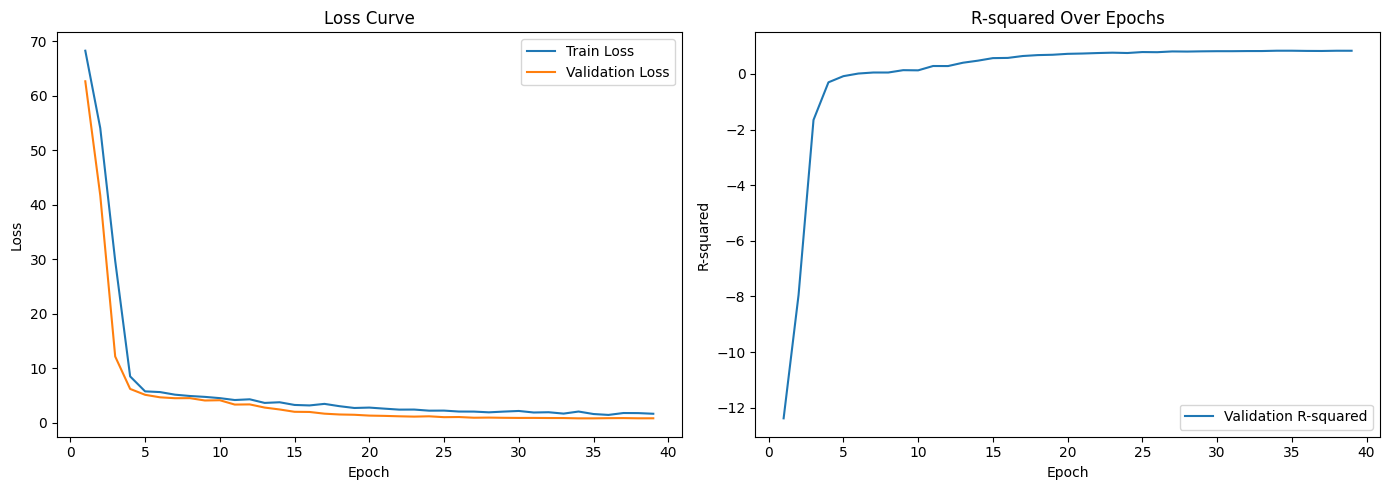

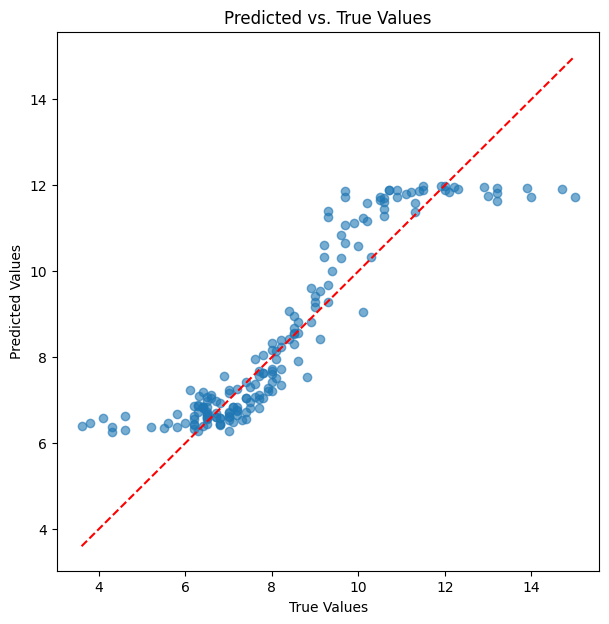

In [26]:
import matplotlib.pyplot as plt

# Assuming you have the history of training losses, validation losses, and R-squared values
epochs = list(range(1, len(train_losses) + 1))

# 1. Plotting the Loss Curve
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# 2. Plotting the R-squared Over Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('R-squared Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Plotting Predicted vs. True Values for Validation Set
plt.figure(figsize=(7, 7))
plt.scatter(val_targets_list, val_predictions, alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.plot([min(val_targets_list), max(val_targets_list)], [min(val_targets_list), max(val_targets_list)], 'r--')  # Diagonal line
plt.show()


In [27]:
# Save the model to a file
model_save_path = 'dietary_transformer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Model saved to dietary_transformer_model.pth


In [28]:
# Load the saved model
model = DietaryTransformerModel(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, hidden_dim=hidden_dim, dropout=dropout)
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()  # Set the model to evaluation mode
print(f'Model loaded from {model_save_path}')


Model loaded from dietary_transformer_model.pth


c:\Users\Ravisun P R\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import numpy as np

# Assuming your data is already preprocessed and scaled
# Convert data to PyTorch tensors
smbg_tensor = torch.tensor(smbg_features_scaled, dtype=torch.float32)
recipe_tensor = torch.tensor(recipe_features_scaled, dtype=torch.float32)
merged_tensor = torch.tensor(merged_features_scaled, dtype=torch.float32)

# Ensure all tensors have the same number of rows
min_size = min(smbg_tensor.shape[0], recipe_tensor.shape[0], merged_tensor.shape[0])
smbg_tensor = smbg_tensor[:min_size]
recipe_tensor = recipe_tensor[:min_size]
merged_tensor = merged_tensor[:min_size]

# Concatenate the tensors along the last dimension (feature dimension)
combined_features_tensor = torch.cat([smbg_tensor, recipe_tensor, merged_tensor], dim=1)
print(f"Combined Features Tensor Shape: {combined_features_tensor.shape}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain enough components to explain 95% of variance
pca_features = pca.fit_transform(combined_features_tensor.numpy())

# Convert PCA features back to a tensor
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)
print(f"PCA Features Tensor Shape: {pca_features_tensor.shape}")

# Assuming you have a target tensor `smbg_targets` aligned with `smbg_tensor`
smbg_targets = smbg_df['HbA1c (%)'].values  # Adjust this to your actual target column
smbg_targets = torch.tensor(smbg_targets[:min_size], dtype=torch.float32)

# Split into training, validation, and test sets
train_features_tensor, test_features_tensor, train_targets_tensor, test_targets_tensor = train_test_split(
    pca_features_tensor, smbg_targets, test_size=0.2, random_state=42
)

train_features_tensor, val_features_tensor, train_targets_tensor, val_targets_tensor = train_test_split(
    train_features_tensor, train_targets_tensor, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

# Create TensorDatasets and DataLoader objects
train_dataset = TensorDataset(train_features_tensor, train_targets_tensor)
val_dataset = TensorDataset(val_features_tensor, val_targets_tensor)
test_dataset = TensorDataset(test_features_tensor, test_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer Model Definition
class DietaryTransformerModel(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, hidden_dim, dropout=0.3):
        super(DietaryTransformerModel, self).__init__()
        
        # Transformer encoder layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim,  # This should match the PCA output dimension
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Match input_dim here
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)  # Output is a single value

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Transformer encoder expects input in [batch_size, sequence_length, input_dim]
        x = self.transformer(x)
        
        # Fully connected layers expect input in [batch_size, input_dim]
        # Flatten sequence length and input_dim for the fully connected layers
        x = x.mean(dim=1)  # Global average pooling over the sequence length
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Initialize the model
input_dim = pca_features_tensor.shape[1]  # Update input dimension based on PCA output
num_layers = 2
num_heads = 2 # Set num_heads to 3 as it divides 9 evenly
hidden_dim = 32
dropout = 0.5

model = DietaryTransformerModel(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, hidden_dim=hidden_dim, dropout=dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses = []
val_losses = []
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_features, batch_targets in train_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        optimizer.zero_grad()
        output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
        loss = criterion(output.squeeze(), batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    # Validation phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_targets_list = []
    with torch.no_grad():
        for batch_features, batch_targets in val_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
            loss = criterion(output.squeeze(), batch_targets)
            val_loss += loss.item()

            val_predictions.extend(output.cpu().numpy())
            val_targets_list.extend(batch_targets.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predictions = np.array(val_predictions).flatten()
    val_targets_list = np.array(val_targets_list).flatten()
    # Calculate R-squared
    r2 = r2_score(val_targets_list, val_predictions)
    r2_scores.append(r2)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, R-squared: {r2:.4f}')
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Testing the model
model.eval()
test_loss = 0
test_predictions = []
test_targets_list = []

with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

        # Forward pass through the model
        output = model(batch_features.unsqueeze(1))  # Unsqueeze to match the input format expected by the model
        loss = criterion(output.squeeze(), batch_targets)
        test_loss += loss.item()

        test_predictions.extend(output.cpu().numpy())
        test_targets_list.extend(batch_targets.cpu().numpy())

test_loss /= len(test_loader)
test_predictions = np.array(test_predictions).flatten()
test_targets_list = np.array(test_targets_list).flatten()

# Calculate R-squared and MSE on the test data
r2 = r2_score(test_targets_list, test_predictions)
mse = mean_squared_error(test_targets_list, test_predictions)
print(f'Test Loss: {test_loss:.4f}, R-squared: {r2:.4f}, MSE: {mse:.4f}')


Combined Features Tensor Shape: torch.Size([890, 12])
PCA Features Tensor Shape: torch.Size([890, 8])
Epoch [1/50], Train Loss: 73.7000, Val Loss: 74.1005, R-squared: -13.1469


c:\Users\Ravisun P R\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/50], Train Loss: 70.0683, Val Loss: 69.0254, R-squared: -12.1709
Epoch [3/50], Train Loss: 63.3386, Val Loss: 58.9961, R-squared: -10.2451
Epoch [4/50], Train Loss: 51.3608, Val Loss: 41.0444, R-squared: -6.8064
Epoch [5/50], Train Loss: 32.4780, Val Loss: 18.3336, R-squared: -2.4594
Epoch [6/50], Train Loss: 12.0792, Val Loss: 5.4299, R-squared: -0.0129
Epoch [7/50], Train Loss: 4.6280, Val Loss: 6.9728, R-squared: -0.3313
Epoch [8/50], Train Loss: 4.3799, Val Loss: 5.3924, R-squared: -0.0204
Epoch [9/50], Train Loss: 3.9333, Val Loss: 4.8967, R-squared: 0.0768
Epoch [10/50], Train Loss: 3.9174, Val Loss: 4.7613, R-squared: 0.1008
Epoch [11/50], Train Loss: 3.7311, Val Loss: 4.3972, R-squared: 0.1698
Epoch [12/50], Train Loss: 3.4350, Val Loss: 3.7950, R-squared: 0.2842
Epoch [13/50], Train Loss: 3.1619, Val Loss: 3.2211, R-squared: 0.3931
Epoch [14/50], Train Loss: 2.9262, Val Loss: 2.6992, R-squared: 0.4917
Epoch [15/50], Train Loss: 2.6258, Val Loss: 2.1608, R-squared: 0.5

In [30]:
# Save the model to a file
model_save_path = 'dietary_transformer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')
 

Model saved to dietary_transformer_model.pth


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Assuming your data is already preprocessed and scaled
# Convert data to PyTorch tensors
smbg_tensor = torch.tensor(smbg_features_scaled, dtype=torch.float32)
recipe_tensor = torch.tensor(recipe_features_scaled, dtype=torch.float32)
merged_tensor = torch.tensor(merged_features_scaled, dtype=torch.float32)

# Ensure all tensors have the same number of rows
min_size = min(smbg_tensor.shape[0], recipe_tensor.shape[0], merged_tensor.shape[0])
smbg_tensor = smbg_tensor[:min_size]
recipe_tensor = recipe_tensor[:min_size]
merged_tensor = merged_tensor[:min_size]

# Concatenate the tensors along the last dimension (feature dimension)
combined_features_tensor = torch.cat([smbg_tensor, recipe_tensor, merged_tensor], dim=1)
print(f"Combined Features Tensor Shape: {combined_features_tensor.shape}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain enough components to explain 95% of variance
pca_features = pca.fit_transform(combined_features_tensor.numpy())

# Convert PCA features back to a tensor
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)
print(f"PCA Features Tensor Shape: {pca_features_tensor.shape}")

# Assuming you have a target tensor `smbg_targets` aligned with `smbg_tensor`
smbg_targets = smbg_df['HbA1c (%)'].values  # Adjust this to your actual target column
smbg_targets = torch.tensor(smbg_targets[:min_size], dtype=torch.float32)

# Split into training, validation, and test sets
train_features_tensor, test_features_tensor, train_targets_tensor, test_targets_tensor = train_test_split(
    pca_features_tensor, smbg_targets, test_size=0.2, random_state=42
)

train_features_tensor, val_features_tensor, train_targets_tensor, val_targets_tensor = train_test_split(
    train_features_tensor, train_targets_tensor, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

# Create TensorDatasets and DataLoader objects
train_dataset = TensorDataset(train_features_tensor, train_targets_tensor)
val_dataset = TensorDataset(val_features_tensor, val_targets_tensor)
test_dataset = TensorDataset(test_features_tensor, test_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer Model Definition
class DietaryTransformerModel(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, hidden_dim, dropout=0.3):
        super(DietaryTransformerModel, self).__init__()
        
        # Transformer encoder layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim,  # This should match the PCA output dimension
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Match input_dim here
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)  # Output is a single value

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Transformer encoder expects input in [batch_size, sequence_length, input_dim]
        x = self.transformer(x)
        
        # Fully connected layers expect input in [batch_size, input_dim]
        # Flatten sequence length and input_dim for the fully connected layers
        x = x.mean(dim=1)  # Global average pooling over the sequence length
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Initialize the model
input_dim = pca_features_tensor.shape[1]  # Update input dimension based on PCA output
num_layers = 2
num_heads = 2 # Set num_heads to 2
hidden_dim = 32
dropout = 0.5

model = DietaryTransformerModel(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, hidden_dim=hidden_dim, dropout=dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses = []
val_losses = []
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_features, batch_targets in train_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        optimizer.zero_grad()
        output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
        loss = criterion(output.squeeze(), batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    # Validation phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_targets_list = []
    with torch.no_grad():
        for batch_features, batch_targets in val_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
            loss = criterion(output.squeeze(), batch_targets)
            val_loss += loss.item()

            val_predictions.extend(output.cpu().numpy())
            val_targets_list.extend(batch_targets.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predictions = np.array(val_predictions).flatten()
    val_targets_list = np.array(val_targets_list).flatten()
    # Calculate R-squared
    r2 = r2_score(val_targets_list, val_predictions)
    r2_scores.append(r2)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, R-squared: {r2:.4f}')
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Testing the model
model.eval()
test_loss = 0
test_predictions = []
test_targets_list = []

with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

        # Forward pass through the model
        output = model(batch_features.unsqueeze(1))  # Unsqueeze to match the input format expected by the model
        loss = criterion(output.squeeze(), batch_targets)
        test_loss += loss.item()

        test_predictions.extend(output.cpu().numpy())
        test_targets_list.extend(batch_targets.cpu().numpy())

test_loss /= len(test_loader)
test_predictions = np.array(test_predictions).flatten()
test_targets_list = np.array(test_targets_list).flatten()

# Calculate R-squared and MSE on the test data
r2 = r2_score(test_targets_list, test_predictions)
mse = mean_squared_error(test_targets_list, test_predictions)
print(f'Test Loss: {test_loss:.4f}, R-squared: {r2:.4f}, MSE: {mse:.4f}')



Combined Features Tensor Shape: torch.Size([890, 12])
PCA Features Tensor Shape: torch.Size([890, 8])
Epoch [1/50], Train Loss: 69.3367, Val Loss: 69.6353, R-squared: -12.2912


c:\Users\Ravisun P R\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [2/50], Train Loss: 65.9694, Val Loss: 64.9365, R-squared: -11.3904
Epoch [3/50], Train Loss: 59.3791, Val Loss: 54.6964, R-squared: -9.4251
Epoch [4/50], Train Loss: 45.7743, Val Loss: 35.4646, R-squared: -5.7374
Epoch [5/50], Train Loss: 24.9466, Val Loss: 12.6597, R-squared: -1.3788
Epoch [6/50], Train Loss: 8.1283, Val Loss: 5.6572, R-squared: -0.0703
Epoch [7/50], Train Loss: 4.7799, Val Loss: 6.4130, R-squared: -0.2232
Epoch [8/50], Train Loss: 4.5424, Val Loss: 5.2642, R-squared: 0.0061
Epoch [9/50], Train Loss: 4.2736, Val Loss: 5.3157, R-squared: -0.0057
Epoch [10/50], Train Loss: 4.1849, Val Loss: 5.2726, R-squared: 0.0015
Epoch [11/50], Train Loss: 3.9126, Val Loss: 5.1168, R-squared: 0.0313
Epoch [12/50], Train Loss: 3.8363, Val Loss: 4.8880, R-squared: 0.0754
Epoch [13/50], Train Loss: 3.8057, Val Loss: 4.6452, R-squared: 0.1218
Epoch [14/50], Train Loss: 3.5211, Val Loss: 4.3331, R-squared: 0.1812
Epoch [15/50], Train Loss: 3.4353, Val Loss: 4.0518, R-squared: 0.234

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Assuming your data is already preprocessed and scaled
# Convert data to PyTorch tensors
smbg_tensor = torch.tensor(smbg_features_scaled, dtype=torch.float32)
recipe_tensor = torch.tensor(recipe_features_scaled, dtype=torch.float32)
merged_tensor = torch.tensor(merged_features_scaled, dtype=torch.float32)

# Ensure all tensors have the same number of rows
min_size = min(smbg_tensor.shape[0], recipe_tensor.shape[0], merged_tensor.shape[0])
smbg_tensor = smbg_tensor[:min_size]
recipe_tensor = recipe_tensor[:min_size]
merged_tensor = merged_tensor[:min_size]

# Concatenate the tensors along the last dimension (feature dimension)
combined_features_tensor = torch.cat([smbg_tensor, recipe_tensor, merged_tensor], dim=1)
print(f"Combined Features Tensor Shape: {combined_features_tensor.shape}")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain enough components to explain 95% of variance
pca_features = pca.fit_transform(combined_features_tensor.numpy())

# Convert PCA features back to a tensor
pca_features_tensor = torch.tensor(pca_features, dtype=torch.float32)
print(f"PCA Features Tensor Shape: {pca_features_tensor.shape}")

# Assuming you have a target tensor `smbg_targets` aligned with `smbg_tensor`
smbg_targets = smbg_df['HbA1c (%)'].values  # Adjust this to your actual target column
smbg_targets = torch.tensor(smbg_targets[:min_size], dtype=torch.float32)

# Split into training, validation, and test sets
train_features_tensor, test_features_tensor, train_targets_tensor, test_targets_tensor = train_test_split(
    pca_features_tensor, smbg_targets, test_size=0.2, random_state=42
)

train_features_tensor, val_features_tensor, train_targets_tensor, val_targets_tensor = train_test_split(
    train_features_tensor, train_targets_tensor, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

# Create TensorDatasets and DataLoader objects
train_dataset = TensorDataset(train_features_tensor, train_targets_tensor)
val_dataset = TensorDataset(val_features_tensor, val_targets_tensor)
test_dataset = TensorDataset(test_features_tensor, test_targets_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer Model Definition
class DietaryTransformerModel(nn.Module):
    def __init__(self, input_dim, num_layers, num_heads, hidden_dim, dropout=0.3):
        super(DietaryTransformerModel, self).__init__()
        
        # Transformer encoder layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim,  # This should match the PCA output dimension
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Match input_dim here
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)  # Output is a single value

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Transformer encoder expects input in [batch_size, sequence_length, input_dim]
        x = self.transformer(x)
        
        # Fully connected layers expect input in [batch_size, input_dim]
        # Flatten sequence length and input_dim for the fully connected layers
        x = x.mean(dim=1)  # Global average pooling over the sequence length
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

# Initialize the model
input_dim = pca_features_tensor.shape[1]  # Update input dimension based on PCA output
num_layers = 2
num_heads = 2
hidden_dim = 32
dropout = 0.5

model = DietaryTransformerModel(input_dim=input_dim, num_layers=num_layers, num_heads=num_heads, hidden_dim=hidden_dim, dropout=dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
best_val_loss = float('inf')
patience = 5
trigger_times = 0
train_losses = []
val_losses = []
r2_scores = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_features, batch_targets in train_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        optimizer.zero_grad()
        output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
        loss = criterion(output.squeeze(), batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    # Validation phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_targets_list = []
    with torch.no_grad():
        for batch_features, batch_targets in val_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

            output = model(batch_features.unsqueeze(1))  # Unsqueeze to add the sequence dimension
            loss = criterion(output.squeeze(), batch_targets)
            val_loss += loss.item()

            val_predictions.extend(output.cpu().numpy())
            val_targets_list.extend(batch_targets.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    val_predictions = np.array(val_predictions).flatten()
    val_targets_list = np.array(val_targets_list).flatten()
    # Calculate R-squared
    r2 = r2_score(val_targets_list, val_predictions)
    r2_scores.append(r2)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, R-squared: {r2:.4f}')
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Testing the model
model.eval()
test_loss = 0
test_predictions = []
test_targets_list = []

with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)

        # Forward pass through the model
        output = model(batch_features.unsqueeze(1))  # Unsqueeze to match the input format expected by the model
        loss = criterion(output.squeeze(), batch_targets)
        test_loss += loss.item()

        test_predictions.extend(output.cpu().numpy())
        test_targets_list.extend(batch_targets.cpu().numpy())

test_loss /= len(test_loader)
test_predictions = np.array(test_predictions).flatten()
test_targets_list = np.array(test_targets_list).flatten()

# Calculate R-squared and MSE on the test data
r2 = r2_score(test_targets_list, test_predictions)
mse = mean_squared_error(test_targets_list, test_predictions)
print(f'Test Loss: {test_loss:.4f}, R-squared: {r2:.4f}, MSE: {mse:.4f}')

# Define the function to recommend recipes based on user inputs
def recommend_recipes(glucose, height, weight, hba1c, model, pca, scaler, recipes_df):
    # Preprocess user input
    user_data = np.array([[glucose, height, weight, hba1c]])
    user_data_scaled = scaler.transform(user_data)

    # Apply PCA transformation
    user_data_pca = pca.transform(user_data_scaled)
    user_data_tensor = torch.tensor(user_data_pca, dtype=torch.float32).unsqueeze(0)

    # Predict HbA1c using the model
    model.eval()
    with torch.no_grad():
        predicted_hba1c = model(user_data_tensor.unsqueeze(1)).item()
    
    print(f"Predicted HbA1c: {predicted_hba1c:.4f}")

    # Recommend recipes based on SMBG levels and carbohydrate content
    if glucose < 70:
        # For low glucose, suggest recipes with higher carbs
        recommended_recipes = recipes_df[recipes_df['carbs'] > 50].head(3)
    elif 70 <= glucose <= 140:
        # For normal glucose, suggest balanced carb recipes
        recommended_recipes = recipes_df[(recipes_df['carbs'] >= 30) & (recipes_df['carbs'] <= 50)].head(3)
    else:
        # For high glucose, suggest low-carb recipes
        recommended_recipes = recipes_df


Combined Features Tensor Shape: torch.Size([890, 12])
PCA Features Tensor Shape: torch.Size([890, 8])
Epoch [1/50], Train Loss: 69.4660, Val Loss: 69.4191, R-squared: -12.2438
Epoch [2/50], Train Loss: 64.6648, Val Loss: 63.0294, R-squared: -11.0167


c:\Users\Ravisun P R\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [3/50], Train Loss: 55.8881, Val Loss: 50.0244, R-squared: -8.5267
Epoch [4/50], Train Loss: 39.4856, Val Loss: 27.0679, R-squared: -4.1320
Epoch [5/50], Train Loss: 16.5406, Val Loss: 6.5835, R-squared: -0.2281
Epoch [6/50], Train Loss: 5.4532, Val Loss: 6.9278, R-squared: -0.3238
Epoch [7/50], Train Loss: 4.7358, Val Loss: 5.1923, R-squared: 0.0201
Epoch [8/50], Train Loss: 4.5074, Val Loss: 4.9498, R-squared: 0.0666
Epoch [9/50], Train Loss: 4.0213, Val Loss: 4.9249, R-squared: 0.0687
Epoch [10/50], Train Loss: 4.0745, Val Loss: 4.6945, R-squared: 0.1122
Epoch [11/50], Train Loss: 3.9699, Val Loss: 4.2941, R-squared: 0.1898
Epoch [12/50], Train Loss: 3.7414, Val Loss: 3.9715, R-squared: 0.2505
Epoch [13/50], Train Loss: 3.4891, Val Loss: 3.5432, R-squared: 0.3310
Epoch [14/50], Train Loss: 3.1593, Val Loss: 2.9824, R-squared: 0.4374
Epoch [15/50], Train Loss: 2.7120, Val Loss: 2.5127, R-squared: 0.5265
Epoch [16/50], Train Loss: 2.5916, Val Loss: 2.0161, R-squared: 0.6222
Epoc